In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
from torch import cat as cc


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class Encoder(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
            nn.ReLU(),
            nn.Flatten(1, -1),
            nn.Linear(128 * 3 * 3, n_out)
        )

    def forward(self, x):
        shape = x.size()
        if len(shape) == 5:
            x = self.net(x.flatten(0, 1)).unflatten(0, shape[0:2])

        else:
            x = self.net(x)
        return x


class Decoder(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128 * 3 * 3),
            nn.ReLU(),
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(0, 0)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(0, 0)),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )

    def forward(self, x):
        shape = x.size()
        if len(shape) == 3:
            x = self.net(x.flatten(0, 1)).unflatten(0, shape[0:2])

        else:
            x = self.net(x)
        return x


class Bernoulli(object):
    def __init__(self, param):
        super().__init__()
        self.param = param
        self.probs = self.param.sigmoid()

    def log_prob(self, x, param_grad=True):

        if param_grad:
            theta = self.probs
        else:
            theta = self.probs.clone().detach()

        log_px = x * (theta + 1e-9).log() + (1. - x) * (1. - theta + 1e-9).log()
        return log_px.sum(dim=-1, keepdim=True)

    def sample(self, det=False):
        if det:
            x = self.probs > 0

        else:
            x = torch.bernoulli(self.probs)

        x = self.probs + (x - self.probs).detach()
        return x


def get_mnist():
    import torch
    from torchvision import datasets

    class DataSet(torch.utils.data.Dataset):
        def __init__(self, train=True):
            dataset = datasets.MNIST(root='../data', train=train, download=True)
            self.data = dataset.data
            self.targ = dataset.targets

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targ[idx]

    train_dataset = DataSet(train=True)
    test_dataset = DataSet(train=False)
    return train_dataset, test_dataset


def log_normal(x, loc, scale):
    return - scale.log() - 0.5 * ((x - loc) / scale).pow(2.) - 0.5 * np.log(2. * math.pi)


def kld_normal(loc1, s1, loc2, s2):  # KL(p1||p2)
    return s2.log() - s1.log() + 0.5 * ((s1 / s2).pow(2.) + ((loc1 - loc2) / s2).pow(2.)) - 0.5


class Gaussian(object):
    def __init__(self, param):
        super().__init__()
        self.param = param
        self.loc, self.scale = self.param.chunk(2, dim=-1)
        self.scale = F.softplus(self.scale) + 1e-11

    def sample(self, det=False):
        if det:
            x = self.loc

        else:
            noise = self.scale * torch.randn_like(self.scale)
            x = self.loc + noise

        return x

    def log_prob(self, x, param_grad=True):
        if param_grad:
            log_px = log_normal(x, self.loc, self.scale)

        else:
            log_px = log_normal(x, self.loc.clone().detach(), self.scale.clone().detach())

        return log_px.sum(dim=-1, keepdim=True)



train_dataset, test_dataset = get_mnist()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [2]:
def code_log_prob(c, x, std=1.):
    xx = x.square().sum(dim=-1, keepdim=True)
    xc = torch.matmul(x.unsqueeze(dim=-2), c.transpose(1, 2).contiguous()).squeeze(dim=-2)
    cc = c.square().sum(dim=-1)
    dist = xx + xc.mul(-2.) + cc
    log_prob = - (1./(2. * std * std)) * dist
    log_prob = log_prob - (np.log(np.sqrt(2. * np.pi)) + np.log(std)) * c.size()[-1]
    return log_prob


class VectorQuantizer(nn.Module):
    def __init__(self, num_heads, num_experts, embedding_size, std=1.):
        super().__init__()
        self.std = std
        self.num_heads, self.num_experts, self.embedding_size = num_heads, num_experts, embedding_size
        self.code = nn.Parameter(torch.randn(num_heads, num_experts, embedding_size), requires_grad=True)
        self.code.data.normal_(0, np.sqrt(1./embedding_size))

class Model(nn.Module):
    def __init__(self, num_experts, embedding_size, num_heads):
        super().__init__()
        self.num_heads, self.num_experts, self.embedding_size = num_heads, num_experts, embedding_size
        self.enc = Encoder(embedding_size * num_heads)
        self.dec = Decoder(embedding_size * num_heads)
        self.code = VectorQuantizer(num_heads, num_experts, embedding_size)

    def encode(self, x):
        return self.enc(x).unflatten(-1, (self.num_heads, self.embedding_size))

    def decode(self, z):
        return self.dec(z.flatten(-2, -1))

    def codebook(self):
        return self.code.code


    


def multihead_select(code, index):
    # index.shape = [..., num_heads]
    # code.shape = [num_heads, num_experts, feature_size]
    code = code.unflatten(0, (*[1 for _ in range(index.ndim - 1)], -1))
    code = code.expand(*index.size(), -1, -1)
    index = index.unflatten(-1, (-1, 1, 1)).expand(*index.size(), 1, code.size()[-1])
    return torch.gather(code, -2, index).squeeze(dim=-2)

def multihead_select2(code, index):
    # index.shape = [..., num_heads]
    # code.shape = [num_heads, num_experts, feature_size]
    
    num_experts, num_heads = code.size()[-2], index.size()[-1]
    assert code.size()[-3] == num_heads, 'code.size()[-3] should be same to index.size()[-1]'

    expert_offset = torch.arange(0, num_experts * num_heads, num_experts).to(index.device)

    index = index + expert_offset

    code = code.flatten(0, 1)
    code = torch.index_select(code, dim=0, index=index.flatten())

    code = code.unflatten(0, index.shape)

    return code



def cat_sample(p, one_hot=True):
    x = torch.multinomial(p.flatten(0, -2), 1, replacement=True).squeeze(-1)
    x = x.unflatten(0, p.shape[: -1])
    if one_hot:
        x = F.one_hot(x, p.size()[-1])
    return x

In [32]:
num_experts = 64
num_heads = 8
embedding_size = 128
model = Model(num_experts, embedding_size, num_heads).to(device)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [33]:
batch_size = 256
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

stats = {'accuracy': [], 'codebook': []}
for epoch in range(100):
    for stat in stats:
        stats[stat].append(0.)

    for x, y in loader:

        x = x.unsqueeze(dim=-3).float() / 255.
        x = x.to(device)
        optimizer.zero_grad()

        enc = model.encode(x)
        codebook = model.codebook()

        commitment_log_prob = code_log_prob(codebook.detach(), enc)
        codebook_log_prob = code_log_prob(codebook, enc.detach())

        vq_id = commitment_log_prob.argmax(dim=-1)
        vq = multihead_select2(codebook, vq_id)
        dec = model.decode(enc + (vq - enc).detach())
        accuracy = Bernoulli(dec).log_prob(x)

        commitment_log_prob = (commitment_log_prob + np.log(1./num_experts)).logsumexp(dim=-1).sum(dim=-1).mean()
        codebook_log_prob = (codebook_log_prob + np.log(1./num_experts)).logsumexp(dim=-1).sum(dim=-1).mean()
        accuracy = accuracy.sum(dim=[-3, -2, -1]).mean()

        loss = - accuracy - commitment_log_prob - codebook_log_prob
        loss.backward()
        optimizer.step()

        commitment_log_prob_item = commitment_log_prob.item()
        codebook_log_prob_item = codebook_log_prob.item()
        accuracy_item = accuracy.item()


        stats['accuracy'][-1] += accuracy_item / len(loader)
        stats['codebook'][-1] += codebook_log_prob_item / len(loader)



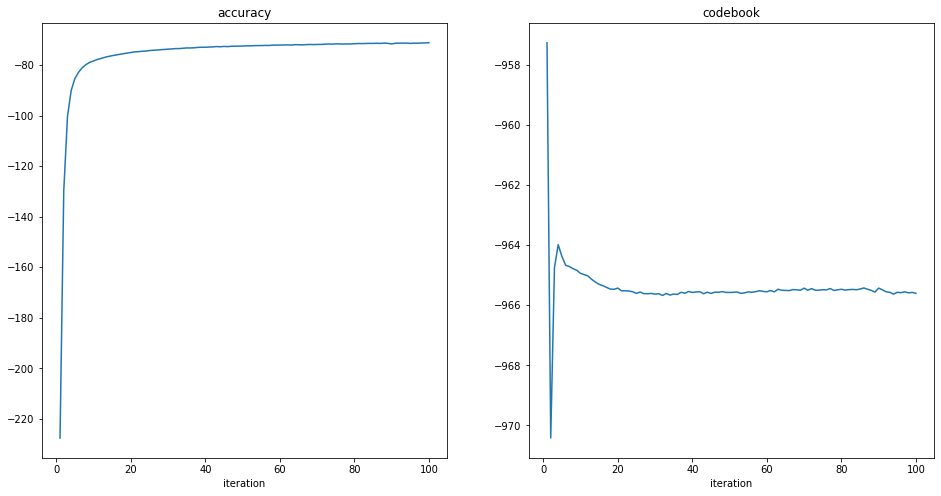

In [35]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(stats['accuracy']) + 1), stats['accuracy'])
ax.set_title('accuracy')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(stats['codebook']) + 1), stats['codebook'])
ax.set_title('codebook')
ax.set_xlabel('iteration')

plt.show()

In [36]:
print('accuracy: {}'.format(stats['accuracy'][-1]))
print('codebook: {}'.format(stats['codebook'][-1]))

accuracy: -71.15970269227644
codebook: -965.6106100489951
